In [1]:
!pip install firebase-admin



Firebase connected successfully
    Day  Water Usage (Liters)            Status
0     1                  1669  ⚠️ Risk Detected
1     2                  1027            Normal
2     3                   998            Normal
3     4                   980            Normal
4     5                  1028            Normal
5     6                  1000            Normal
6     7                  1022            Normal
7     8                  1006            Normal
8     9                   970            Normal
9    10                   953            Normal
10   11                   951            Normal
11   12                  1443  ⚠️ Risk Detected
12   13                  1045            Normal
13   14                  1564  ⚠️ Risk Detected
14   15                   997            Normal


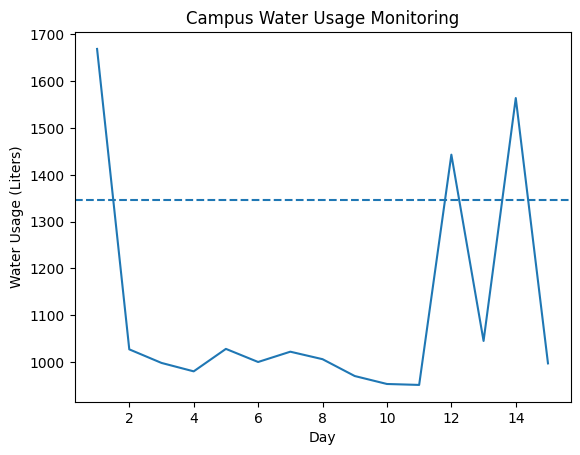

Water usage data sent to Firebase
🚨 ALERT: Infrastructure risk detected BEFORE complaints
Suggested action: Inspect water tank / pipeline


In [24]:
# --- Firebase setup ---
import firebase_admin
from firebase_admin import credentials, db

if not firebase_admin._apps:
    cred = credentials.Certificate(
        "invisible-infra-2fa6c-firebase-adminsdk-fbsvc-b4c5853464.json"
    )
    firebase_admin.initialize_app(cred, {
        "databaseURL": "https://invisible-infra-2fa6c-default-rtdb.firebaseio.com/"
    })

print("Firebase connected successfully")


# --- DEMO MODE: clear old data ---
db.reference("water_usage").delete()

# --- Generate fake water usage data ---
import random
import pandas as pd
import matplotlib.pyplot as plt

days = list(range(1, 16))
usage = []

for day in days:
    # 80% chance normal, 20% chance abnormal
    if random.random() < 0.8:
        usage.append(random.randint(950, 1050))    # normal
    else:
        usage.append(random.randint(1400, 1700))   # abnormal


df = pd.DataFrame({
    "Day": days,
    "Water Usage (Liters)": usage
})

# --- Anomaly detection ---
normal_mean = df["Water Usage (Liters)"][:9].mean()
threshold = normal_mean * 1.25

df["Status"] = df["Water Usage (Liters)"].apply(
    lambda x: "⚠️ Risk Detected" if x > threshold else "Normal"
)

print(df)

# --- Plot ---
plt.plot(df["Day"], df["Water Usage (Liters)"])
plt.axhline(y=threshold, linestyle="--")
plt.xlabel("Day")
plt.ylabel("Water Usage (Liters)")
plt.title("Campus Water Usage Monitoring")
plt.show()

# --- Push data to Firebase ---
ref = db.reference("water_usage")

for i in range(len(df)):
    ref.push({
        "day": int(df.iloc[i]["Day"]),
        "usage": int(df.iloc[i]["Water Usage (Liters)"]),
        "status": df.iloc[i]["Status"]
    })

print("Water usage data sent to Firebase")

# --- Read from Firebase & trigger alert ---
data = ref.get()

for value in data.values():
    if value["status"] == "⚠️ Risk Detected":
        print("🚨 ALERT: Infrastructure risk detected BEFORE complaints")
        print("Suggested action: Inspect water tank / pipeline")
        break
else:
    print("✅ All systems operating normally")
